Notes:
1. streamline testing system. Save all stats for each test run, the visuals AND the data, the confusion matrix, the statedict, high level description of arch
2. collect miss classification for display
3. remember to keep starting weights, init a model and save it start models
4. save specific data presentations
4. need workflow for data collection work flow and non data colleciton workflow
5. handle display with seaborne, pack data into panda dataframes

In [169]:
# imports

import os
import torch
import numpy as np
import sklearn


In [170]:
# get device

device = "cuda" if torch.cuda.is_available() else "cpu"

In [171]:
# get dtype, not all devices can handle half precision

dtype = torch.float16 if device == "cuda" else torch.float

In [172]:
# raw data loader

file_train_data = 'data/train-images.pth'
file_train_label = 'data/train-labels.pth'
file_test_data = 'data/test-images.pth'
file_test_label = 'data/test-labels.pth'

train_data_tensor = torch.load(file_train_data).to(device).to(dtype)
train_label_tensor = torch.load(file_train_data).to(device).to(dtype)
test_data_tensor = torch.load(file_train_data).to(device).to(dtype)
test_label_tensor = torch.load(file_train_data).to(device).to(dtype)



In [173]:
# cleaning and transforming, different types

# images should be binary correct?

In [174]:
# seperate into train, valid and test sets with skilearn

from sklearn.model_selection import train_test_split

test_data_np, train_data_np, test_label_np, train_label_np = train_test_split(data, labels, test_size=0.8)


In [175]:
# Convert to tensors, align shapes, datatypes and device
# shape = (len(test_data_np), 1)

test_data = torch.tensor(test_data_np, dtype=dtype, device=device).reshape(len(test_data_np), 1)
test_label = torch.tensor(test_label_np, dtype=dtype, device=device).reshape(len(test_label_np), 1)
train_data = torch.tensor(train_data_np, dtype=dtype, device=device).reshape(len(train_data_np), 1)
train_label = torch.tensor(train_label_np, dtype=dtype, device=device).reshape(len(train_label_np), 1)



In [228]:
# init data set

from torch.utils.data import Dataset

class Data(Dataset):
    def __init__(self, train, label):
        self.data = train
        self.label = label
      
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
        
train_set = Data(train_data, train_label)

In [229]:
# prep dataloader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=int(len(train_data_np)*.25), shuffle=True) 

In [231]:
# build model / load state dict / load whole model / explicitly init param weights
import models

model = models.Model0_2()
model.to(dtype)
model.to(device)


Model0_2(
  (lin1): Linear(in_features=1, out_features=50, bias=True)
  (lin2): Linear(in_features=50, out_features=50, bias=True)
  (lin3): Linear(in_features=50, out_features=1, bias=True)
)

torch.float32
torch.float32


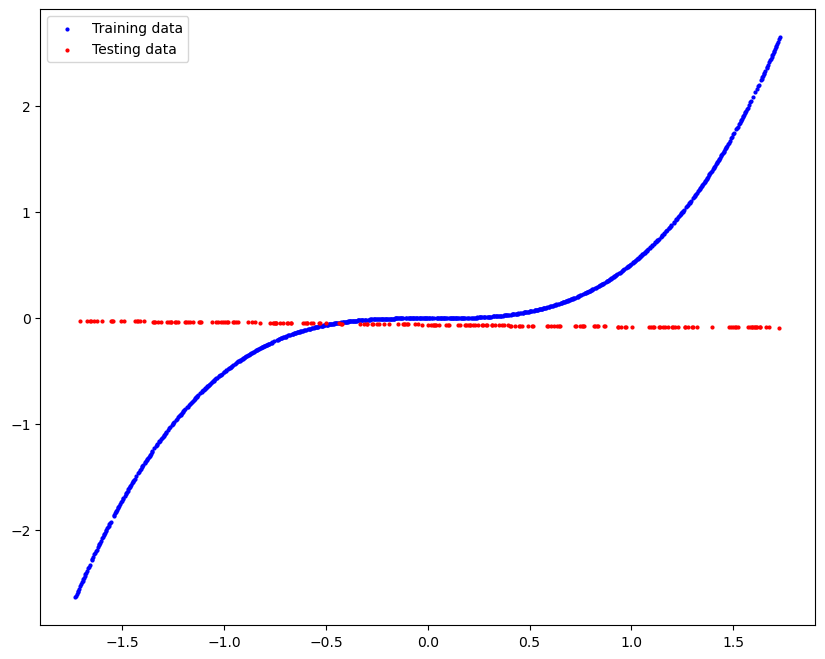

OrderedDict([('lin1.weight',
              tensor([[ 2.0708e-01],
                      [-8.6649e-01],
                      [ 7.1161e-01],
                      [ 7.9441e-01],
                      [-1.7368e-01],
                      [-2.4783e-02],
                      [ 1.6290e-01],
                      [ 7.7814e-02],
                      [-2.7272e-02],
                      [ 8.7727e-01],
                      [ 3.9249e-01],
                      [-7.7424e-01],
                      [ 3.3980e-01],
                      [ 5.0488e-01],
                      [-7.6333e-01],
                      [-2.5399e-01],
                      [ 8.7401e-01],
                      [-4.3322e-01],
                      [ 5.3495e-01],
                      [-3.1193e-01],
                      [-6.4742e-02],
                      [-3.7261e-01],
                      [ 6.3193e-01],
                      [ 8.4330e-01],
                      [ 9.4329e-01],
                      [-8.6731e-01],
         

In [232]:
# check for runtime errors / init predictions

from visuals.display import train_v_test

for i in model.parameters():
    print(i.dtype)
    break
print(test_data.dtype)

with torch.inference_mode():
    preds = model(test_data.reshape(len(test_data_np), 1))
    
train_v_test(train_data, train_label, test_data, preds.numpy())
model.state_dict()

In [233]:
# set up hyperparameters
epochs = 100
optim = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.6)
error = torch.nn.MSELoss()

In [234]:
# init tensorboard, use event monitor or profiler?

In [235]:
# train model, no dataloader, manual batching
model.train()
for _ in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        pred = model(data)
        '''for i in zip(train_pred, train_label):
            print(i)'''
        loss = error(pred, target)
        optim.zero_grad()
        loss.backward()
        optim.step()

In [236]:
# train model, with dataloader

In [ ]:
# need data collect and no collect modes

In [237]:
# run model

with torch.inference_mode():
    preds = model(test_data.reshape(len(test_data_np), 1))
    

    

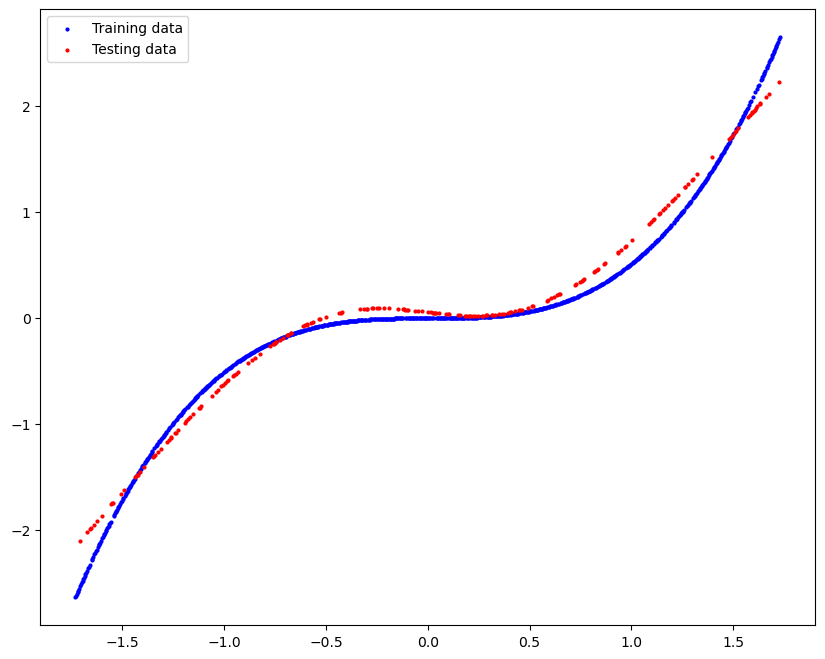

OrderedDict([('lin1.weight',
              tensor([[ 0.2063],
                      [-0.7571],
                      [ 0.6198],
                      [ 0.6613],
                      [-0.2237],
                      [-0.1143],
                      [ 0.1997],
                      [ 0.1598],
                      [-0.0057],
                      [ 0.5135],
                      [ 0.3980],
                      [-0.8192],
                      [ 0.3690],
                      [ 0.4943],
                      [-0.6222],
                      [-0.3209],
                      [ 0.7777],
                      [-0.4370],
                      [ 0.4584],
                      [-0.3959],
                      [-0.0976],
                      [-0.4158],
                      [ 0.5455],
                      [ 0.7689],
                      [ 0.8570],
                      [-0.6412],
                      [ 0.7492],
                      [ 0.0718],
                      [-0.6950],
              

In [238]:
# eval model -- tensorboard, events, profiler, take predictions overtime and create a seaborn graph
train_v_test(train_data, train_label, test_data, preds.numpy())
model.state_dict()

In [ ]:
# eval learning, scatterplots, learning rate, confusion matrixes

In [ ]:
# improve model

In [ ]:
# save model state dict

In [32]:
# save entire model
print(os.getcwd())
cwd = os.getcwd()
path = os.path.join(cwd, 'trained_models')
path = os.path.join(path, f'{model}_linear.pth')
print(path)
torch.save(model, path)

C:\Users\Daily\mynn\workflow
True
C:\Users\Daily\mynn\workflow\1-10-10-10-1_linear.pth
